# Forecasting Bike Shares in London

by Wong Tran

**References**

- [London Bike Sharing dataset](https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset)
- [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html)
- [The impact of weather conditions on cycling counts in Auckland, New Zealand](https://cdn.rawgit.com/nicolasfauchereau/Auckland_Cycling/master/notebooks/Auckland_cycling_and_weather.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import day_abbr, month_abbr, mdays
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
import datetime
import holidays

<br>
<br>

## Read Data

In [2]:
bike_share_df = pd.read_csv("data/london_merged.csv", parse_dates=True)
bike_share_df['timestamp'] = pd.to_datetime(bike_share_df['timestamp'])
bike_share_df = bike_share_df.set_index('timestamp')

idx = pd.date_range(
    bike_share_df.index.min(), 
    bike_share_df.index.max(),
    freq='H'
)

# Interpolate missing values
bike_share_df = bike_share_df.reindex(idx, fill_value=np.nan)
missing_idx = bike_share_df[bike_share_df.cnt.isna()==True].index
bike_share_df = bike_share_df.interpolate()
bike_share_df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


<br>
<br>

## Plot Seasonal Cycle

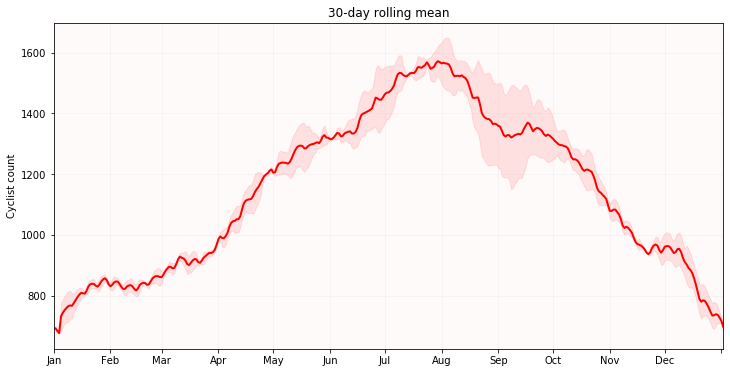

In [3]:
seas_cycl = bike_share_df.cnt.rolling(
    window=30*24,
    center=True, 
    min_periods=20).mean().groupby(bike_share_df.index.dayofyear).mean()

q25 = bike_share_df.cnt.rolling(
    window=30*24,
    center=True, 
    min_periods=20).mean().groupby(bike_share_df.index.dayofyear).quantile(0.25)

q75 = bike_share_df.cnt.rolling(
    window=30*24,
    center=True, 
    min_periods=20).mean().groupby(bike_share_df.index.dayofyear).quantile(0.75)


f, ax = plt.subplots(figsize=(12,6)) 
seas_cycl.plot(
    ax=ax,
    lw=2,
    color='r',
    legend=False
)
ax.fill_between(
    seas_cycl.index,
    q25.values.ravel(), 
    q75.values.ravel(),
    color='r',
    alpha=0.1
)
plt.grid(alpha=0.1)
plt.title("30-day rolling mean")
plt.ylabel("Cyclist count")
ndays_m = np.cumsum(mdays)
ax.set_facecolor("snow")
ax.set_xticks(ndays_m)
ax.set_xticklabels(month_abbr[1:]);

<br>
<br>

## Hourly vs Weekly heatmap

In [4]:
hour_week = bike_share_df[['cnt']].copy()
hour_week['Day'] = hour_week.index.dayofweek
hour_week['Hour'] = hour_week.index.hour
hour_week = hour_week.groupby(['Day','Hour']).mean().unstack()
hour_week.columns = hour_week.columns.droplevel(0)
hour_week.index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

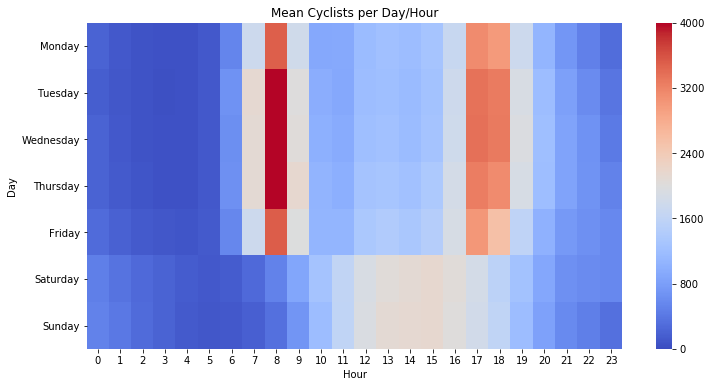

In [5]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
sns.heatmap(
    hour_week, 
    cmap='coolwarm',  # plt.cm.gray_r, 
    ax=ax, 
    vmax=4000,
    vmin=0
)
plt.title("Mean Cyclists per Day/Hour")
plt.ylabel("Day");

<br>
<br>

## Annual Weekday vs Weekend trends

In [6]:
weekday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
weekend = ["Saturday", "Sunday"]

weekday_counts = bike_share_df[bike_share_df.index.day_name().isin(weekday)].cnt
weekend_counts = bike_share_df[bike_share_df.index.day_name().isin(weekend)].cnt
weekday_counts = weekday_counts.groupby(weekday_counts.index.hour).describe()
weekend_counts = weekend_counts.groupby(weekend_counts.index.hour).describe()

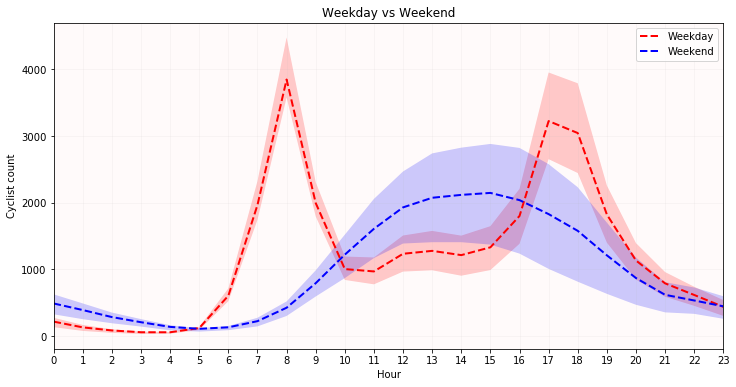

In [7]:
f, ax = plt.subplots(figsize=(12,6)) 
ax.plot(
    weekday_counts.index, 
    weekday_counts['mean'],
    color='r',  # 'k',
    label='Weekday',
    ls='--',
    lw=2
)
ax.fill_between(
    weekday_counts.index,
    weekday_counts['25%'],
    weekday_counts['75%'],
#     hatch='///',
    facecolor='r',  # '0.8',
    alpha=0.2
)

ax.plot(
    weekend_counts.index,
    weekend_counts['mean'],
    color='b',  # 'k',
    label='Weekend',
    ls='--', 
    lw=2
)
ax.fill_between(
    weekend_counts.index,
    weekend_counts['25%'],
    weekend_counts['75%'], 
#     hatch='\\\\\\',
    facecolor='b',  # '0.8',
    alpha=0.2
)
ax.set_facecolor("snow")
plt.xticks([hr for hr in range(0,24)])
plt.xlim(0,23)
plt.grid(alpha=0.1)
plt.title("Weekday vs Weekend")
plt.xlabel("Hour")
plt.ylabel("Cyclist count")
plt.legend();

<br>
<br>

## Daily/Hourly Time Series

**Daily**

- Two outliers during July 2015 and August 2015 will be removed before forecasting

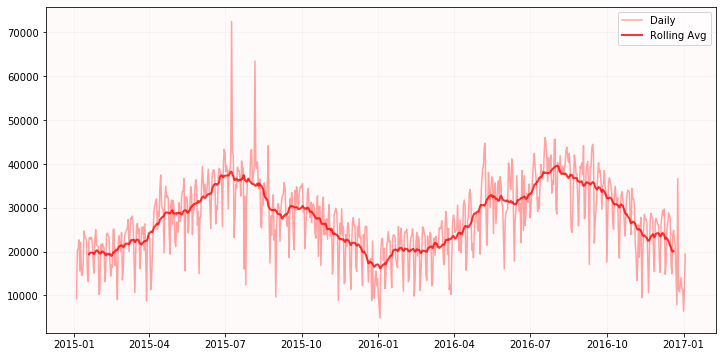

In [8]:
f, ax = plt.subplots(figsize=(12,6))
data = bike_share_df.resample('D').sum().copy()
ax.plot(data.index, data['cnt'], c='r', alpha=0.35, label='Daily')
rolling_data = data.rolling(window=30, center=True).mean()
ax.plot(rolling_data.index, rolling_data['cnt'], ls='-', lw=2, color='r', alpha=0.8, label='Rolling Avg')
plt.grid(alpha=0.1)
plt.legend()
# plt.xlim('2015-01-01', '2017-01-05')
ax.set_facecolor("snow");

**Hourly**

- Different daily cycle for weekday (bimodal) vs weekend (unimodal) clearly visible
- Cyclist count increases on Chirstmas day


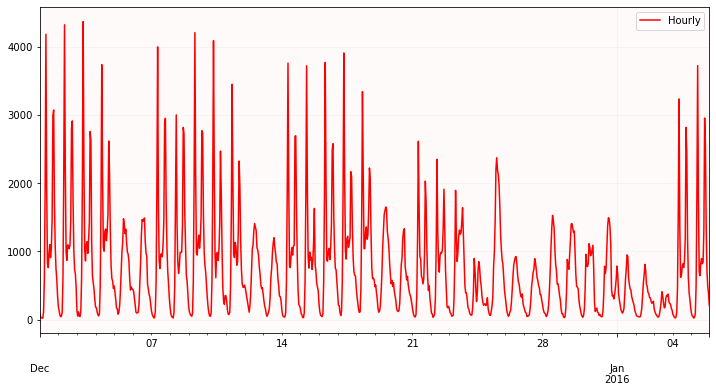

In [46]:
f, ax = plt.subplots(figsize=(12,6))
bike_share_df['cnt']['2015-12-01':'2016-01-5'].plot(c='r', ax=ax, label='Hourly')
plt.grid(alpha=0.1)
plt.legend()
ax.set_facecolor("snow");

<br>
<br>

## Daily forecast

Resample the series to daily (sum) counts and average temperature/weather features

In [15]:
def add_future_avgs(future, data, col):
    future, data = future.copy(), data.copy()
    historical_values = future[future.ds.isin(data.ds)].copy()
    future_values = future[~future.ds.isin(data.ds)].copy()
    historical_values[col] = data[col].values
    
    future_values['DayOfYear'] = future_values.ds.dt.dayofyear
    data['DayOfYear'] = data.ds.dt.dayofyear
    mean_values = data.groupby(['DayOfYear'])[col].mean().reset_index()
    future_values = future_values.merge(mean_values, on=['DayOfYear'], how='left')
    future_values.drop(columns=['DayOfYear'], inplace=True)
    
    future[col] = pd.concat([historical_values, future_values])[col].reset_index(drop=True)
    
    return future

def sample_future_weather(future, data, col):
    future, data = future.copy(), data.copy()
    historical_values = future[future.ds.isin(data.ds)].copy()
    future_values = future[~future.ds.isin(data.ds)].copy()
    historical_values[col] = data[col].values
    
    future_values['DayOfYear'] = future_values.ds.dt.dayofyear
    data['DayOfYear'] = data.ds.dt.dayofyear
    sample_weather = data.groupby('DayOfYear')[col].apply(pd.DataFrame.sample, n=1).reset_index().drop(columns='level_1')
    future_values = future_values.merge(sample_weather, how='left', on='DayOfYear')
    future_values.drop(columns='DayOfYear', inplace=True)
    
    future[col] = pd.concat([historical_values, future_values])[col].reset_index(drop=True)
    
    return future

def is_weekend(ds):
    return (ds.dayofweek == 5) | (ds.dayofweek == 6)

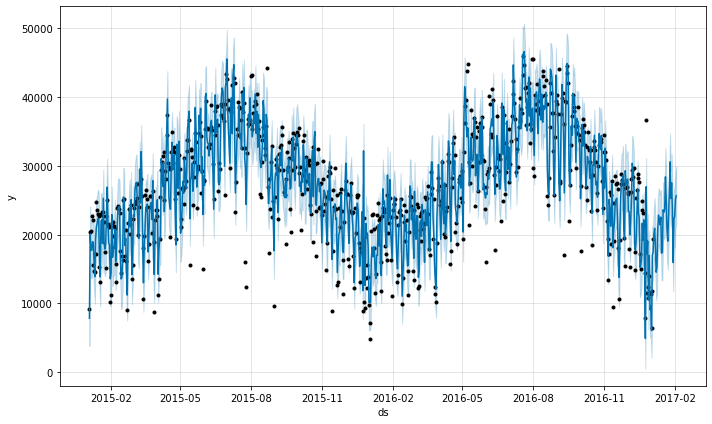

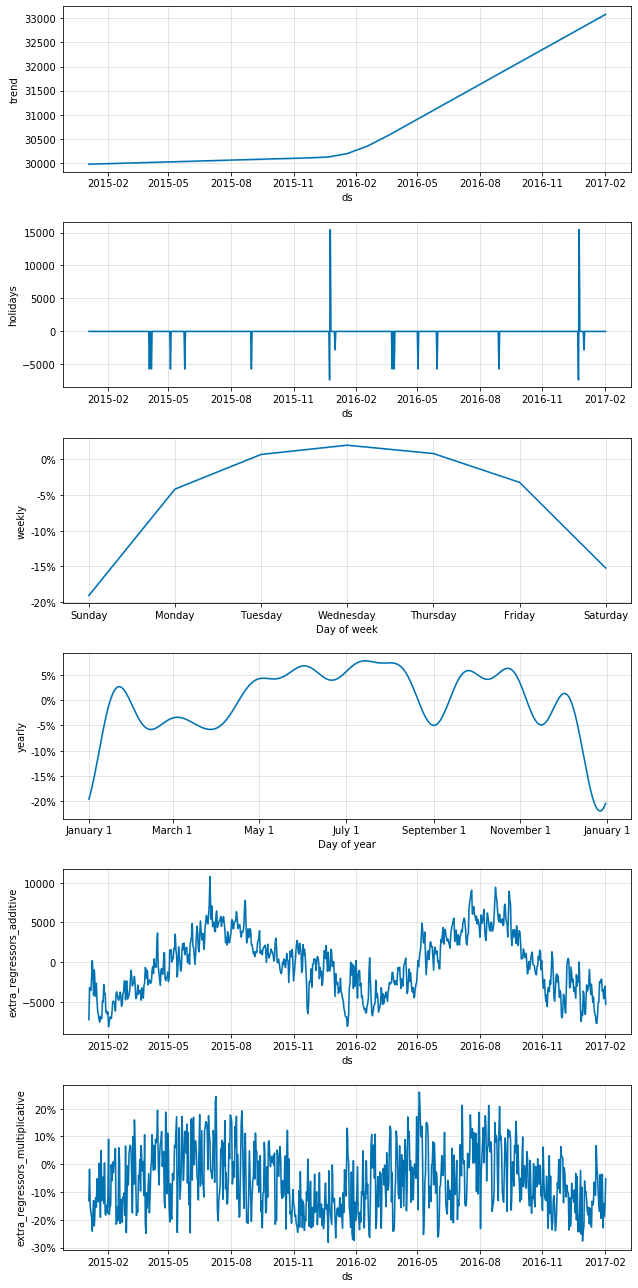

In [16]:
from fbprophet import Prophet

# Holidays
holidays = bike_share_df.reset_index().groupby(pd.Grouper(key='index', freq='D'))['is_holiday'].max().reset_index().rename(columns={'index':'ds', 'is_holiday':'holiday'})
holidays = holidays.drop(index=holidays[holidays.holiday==0].index)
holidays = pd.concat((holidays[['holiday']], holidays[['ds']]), axis=1)
holidays['holiday'] = holidays.holiday.replace({1.0:'Holiday'}).astype(str)
holidays['lower_window'] = 0
holidays['upper_window'] = 0

# 2015
holidays.drop(index = holidays[(holidays.ds>pd.datetime(2015,12,25)) & (holidays.ds<pd.datetime(2016,1,1))].index, inplace=True)
holidays.loc[holidays.ds==pd.datetime(2015,12,25), 'holiday'] = 'Christmas'
holidays = holidays.append(pd.DataFrame(dict(holiday=['Christmas Eve'], ds=[pd.datetime(2015,12,24)], lower_window=[0], upper_window=[0])), ignore_index=True)
holidays.loc[holidays.ds==pd.datetime(2016,1,1), 'holiday'] = 'New Years Day'

# 2016
holidays.drop(index = holidays[(holidays.ds>pd.datetime(2016,12,25)) & (holidays.ds<pd.datetime(2017,1,1))].index, inplace=True)
holidays.drop(index = holidays[(holidays.ds>pd.datetime(2016,12,31))].index, inplace=True)
holidays = holidays.append(pd.DataFrame(dict(holiday=['Christmas'], ds=[pd.datetime(2016,12,25)], lower_window=[0], upper_window=[0])), ignore_index=True)
holidays = holidays.append(pd.DataFrame(dict(holiday=['Christmas Eve'], ds=[pd.datetime(2016,12,24)], lower_window=[0], upper_window=[0])), ignore_index=True)
holidays = holidays.append(pd.DataFrame(dict(holiday=['New Years Day'], ds=[pd.datetime(2017,1,1)], lower_window=[0], upper_window=[0])), ignore_index=True)
holidays.sort_values('ds').reset_index(drop=True)

# Resample data
data = bike_share_df[['cnt']].resample('D').sum().reset_index()
data = data.merge(bike_share_df[['t1', 'hum', 'wind_speed']].resample('D').mean().reset_index(), on='index', how='left')
data = data.merge(bike_share_df.reset_index().groupby(pd.Grouper(key='index', freq='D'))['weather_code'].max().reset_index(), on='index', how='left')
data.columns = ['ds', 'y'] + data.iloc[:,2:].columns.tolist()
data['rain_thunder_snow'] = data['weather_code'] >= 7
data = data.drop(columns='weather_code')
data.loc[data.y>50000, 'y'] = None
data

# Build model
m = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth='linear',
    n_changepoints=20,
    holidays=holidays,
    holidays_prior_scale=20
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=10,
    prior_scale=30,  # 20
    mode='multiplicative'
).add_seasonality(
    name='yearly',
    period=365,
    fourier_order=10,
    prior_scale=20,
    mode='multiplicative'
).add_regressor(
    name='t1',
    mode='additive',
    prior_scale=5
).add_regressor(
    name='hum',
    mode='multiplicative',
    prior_scale=5
).add_regressor(
    name='wind_speed',
    mode='multiplicative',
    prior_scale=5
).add_regressor(
    name='rain_thunder_snow',
    mode='multiplicative',
    prior_scale=5
)

m.fit(data)

future = m.make_future_dataframe(30, freq='D')
future = add_future_avgs(future, data, 't1')
future = add_future_avgs(future, data, 'hum')
future = add_future_avgs(future, data, 'wind_speed')
future = sample_future_weather(future, data, 'rain_thunder_snow')

forecast = m.predict(future)

fig = m.plot(forecast)
f = m.plot_components(forecast)

In [17]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

cv_results = cross_validation(
    m, 
    initial='375 days',
    horizon='14 days',
    period='21 days'
)
horizon_p_metrics = performance_metrics(cv_results)
mean_absolute_percentage_error(cv_results.y, cv_results.yhat)

cv_results['is_weekend'] = cv_results['ds'].apply(is_weekend)
cv_results['is_weekday'] = ~cv_results['ds'].apply(is_weekend)
print(f"Weekday MAPE: {mean_absolute_percentage_error(cv_results[cv_results.is_weekday==True].y, cv_results[cv_results.is_weekday==True].yhat)}")
print(f"Weekend MAPE: {mean_absolute_percentage_error(cv_results[cv_results.is_weekday==False].y, cv_results[cv_results.is_weekday==False].yhat)}")

INFO:fbprophet:Making 17 forecasts with cutoffs between 2016-01-19 00:00:00 and 2016-12-20 00:00:00


Weekday MAPE: 10.398118645630433
Weekend MAPE: 17.04214526129505


Without Christmas Day

In [18]:
cv_results_copy = cv_results.copy()
cv_results_copy.set_index('ds', inplace=True)
cv_results_copy.drop(index=cv_results_copy[cv_results_copy.index == '2016-12-25'].index, inplace=True)
print(f"Weekday MAPE: {mean_absolute_percentage_error(cv_results_copy[cv_results_copy.is_weekday==True].y, cv_results_copy[cv_results_copy.is_weekday==True].yhat)}")
print(f"Weekend MAPE: {mean_absolute_percentage_error(cv_results_copy[cv_results_copy.is_weekday==False].y, cv_results_copy[cv_results_copy.is_weekday==False].yhat)}")

Weekday MAPE: 10.398118645630433
Weekend MAPE: 16.499881888243316


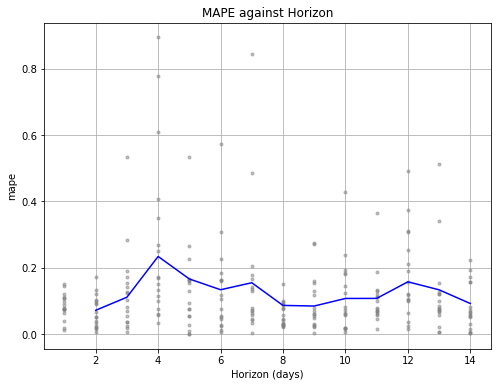

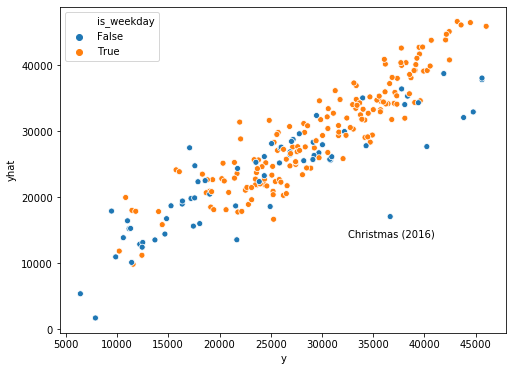

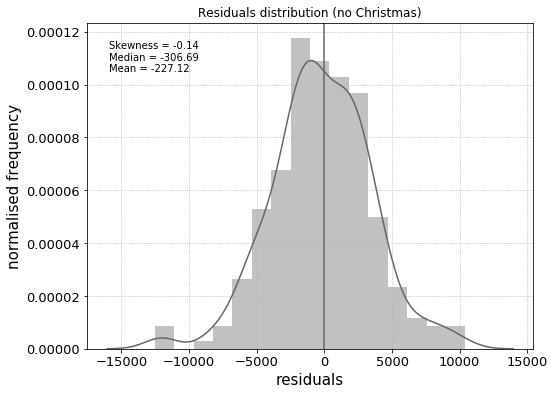

In [48]:
fig = plot_cross_validation_metric(cv_results, metric='mape', figsize=(8,6))
plt.title("MAPE against Horizon")


f, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(x="y", y="yhat", hue="is_weekday", data=cv_results)
# ax = sns.jointplot('y', 'yhat', cv_results, kind='reg', height=8)
ax.text(32500, 14000, 'Christmas (2016)', fontsize=10);

residuals = cv_results.yhat - cv_results.y
residuals = residuals[residuals>-18000]

f, ax = plt.subplots(figsize=(8,6))
sns.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];
ax.axvline(0, color='0.4')
ax.set_title('Residuals distribution (no Christmas)', fontsize=12)
ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=10, transform=ax.transAxes);

<br>
<br>

## Hourly forecast

Transform hourly series using a Yeo-Johnson transform in order to produce non-negative forecasts. In practice I have found this to perform better (for this particular series) than forecasting on the original series and clipping below.

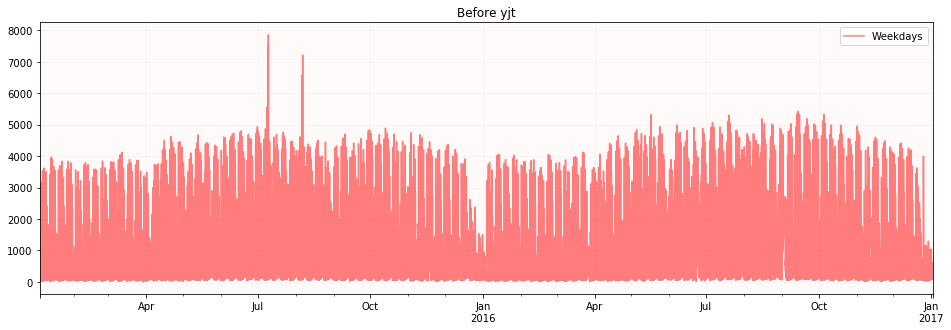

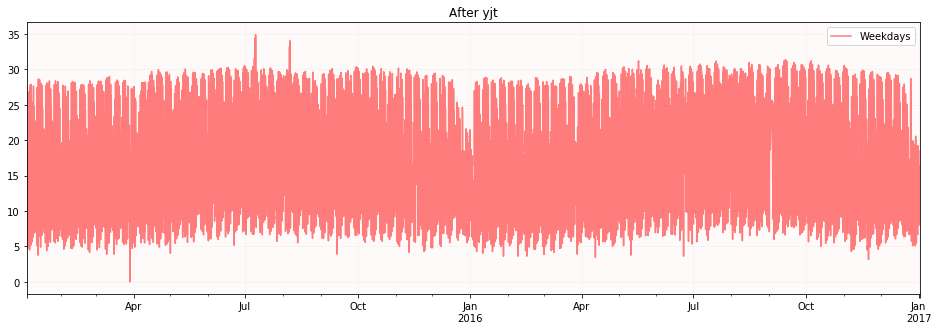

In [3]:
f, ax = plt.subplots(figsize=(16,5))
bike_share_df['2015-01-01':'2017-01-01']['cnt'].plot(c='r', ax=ax, label='Weekdays', alpha=0.5)
plt.grid(alpha=0.1)
plt.title("Before yjt")
plt.legend()
ax.set_facecolor("snow");

yjt = PowerTransformer(method='yeo-johnson', standardize=False)
bike_share_df['yjt_cnt'] = yjt.fit_transform(bike_share_df[['cnt']])

f, ax = plt.subplots(figsize=(16,5))
bike_share_df['2015-01-01':'2017-01-01']['yjt_cnt'].plot(c='r', ax=ax, label='Weekdays', alpha=0.5)
plt.grid(alpha=0.1)
plt.title("After yjt")
plt.legend()
ax.set_facecolor("snow");

<br>
<br>

In [49]:
def add_future_avgs(future, data, col):
    future, data = future.copy(), data.copy()
    historical_values = future[future.ds.isin(data.ds)].copy()
    future_values = future[~future.ds.isin(data.ds)].copy()
    historical_values[col] = data[col].values
    
    future_values['DayOfYear'] = future_values.ds.dt.dayofyear
    future_values['TimeOfDay'] = future_values.ds.dt.time
    data['DayOfYear'] = data.ds.dt.dayofyear
    data['TimeOfDay'] = data.ds.dt.time
    mean_values = data.groupby(['DayOfYear', 'TimeOfDay'])[col].mean().reset_index()
    future_values = future_values.merge(mean_values, on=['DayOfYear', 'TimeOfDay'], how='left')
    future_values.drop(columns=['DayOfYear', 'TimeOfDay'], inplace=True)
    
    future[col] = pd.concat([historical_values, future_values])[col].reset_index(drop=True)
    
    return future

def sample_future_weather(future, data, col):
    future, data = future.copy(), data.copy()
    historical_values = future[future.ds.isin(data.ds)].copy()
    future_values = future[~future.ds.isin(data.ds)].copy()
    historical_values[col] = data[col].values
    
    future_values['DayOfYear'] = future_values.ds.dt.dayofyear
    data['DayOfYear'] = data.ds.dt.dayofyear
    sample_weather = data.groupby('DayOfYear')[col].apply(pd.DataFrame.sample, n=1).reset_index().drop(columns='level_1')
    future_values = future_values.merge(sample_weather, how='left', on='DayOfYear')
    future_values.drop(columns='DayOfYear', inplace=True)
    
    future[col] = pd.concat([historical_values, future_values])[col].reset_index(drop=True)
    
    return future

def rain_thunder_snow(weather_code):
    return (weather_code==7) | (weather_code==10) | (weather_code==26)

def is_weekend(ds):
    return (ds.dayofweek == 5) | (ds.dayofweek == 6)

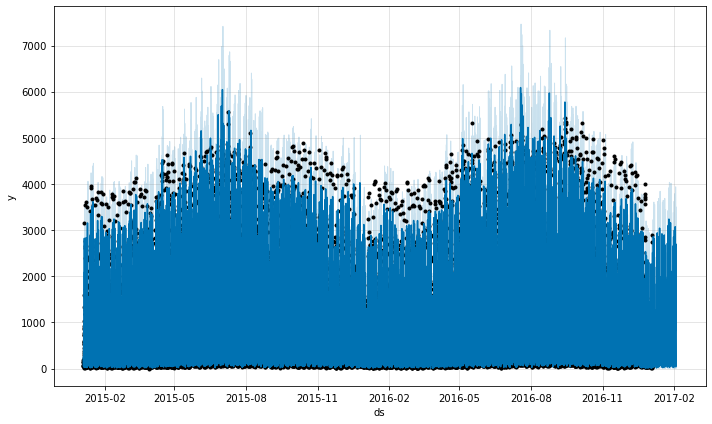

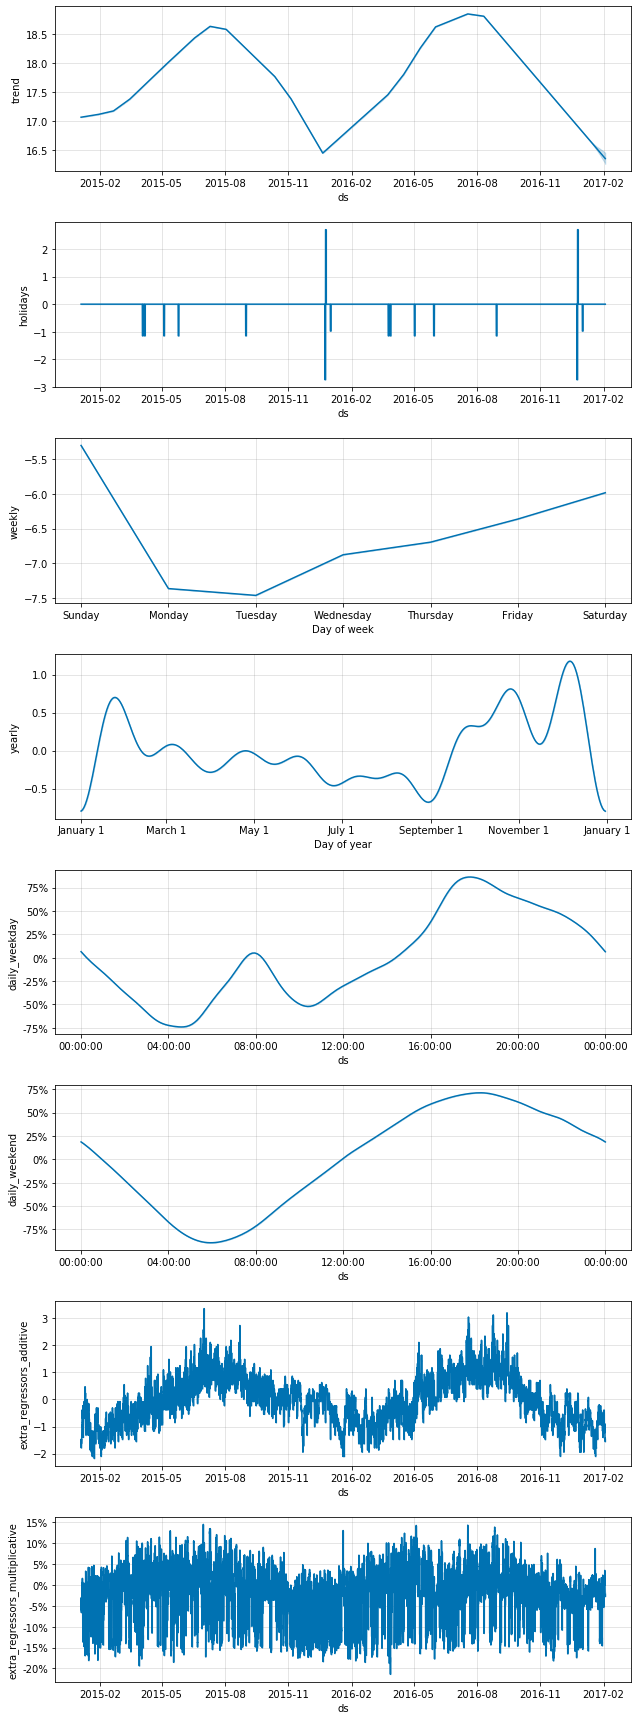

In [50]:
from fbprophet import Prophet

data = bike_share_df[['cnt']].reset_index().copy()
data.columns = ['ds', 'y']
data.loc[data.y>6000, 'y'] = None
yjt = PowerTransformer(method='yeo-johnson', standardize=False)
data['y'] = yjt.fit_transform(data[['y']])
data['is_weekend'] = data['ds'].apply(is_weekend)
data['is_weekday'] = ~data['ds'].apply(is_weekend)
data['t1'] = bike_share_df['t1'].values
data['hum'] = bike_share_df['hum'].values
data['wind_speed'] = bike_share_df['wind_speed'].values
data['weather_code'] = bike_share_df['weather_code'].values
data['rain_thunder_snow'] = data['weather_code'].apply(rain_thunder_snow).astype(int)
data.drop(columns='weather_code', inplace=True)
data['is_weekend'] = data['ds'].apply(is_weekend)
data['is_weekday'] = ~data['ds'].apply(is_weekend)

# Holidays
holidays = bike_share_df.reset_index().groupby(pd.Grouper(key='index', freq='D'))['is_holiday'].max().reset_index().rename(columns={'index':'ds', 'is_holiday':'holiday'})
holidays = holidays.drop(index=holidays[holidays.holiday==0].index)
holidays = pd.concat((holidays[['holiday']], holidays[['ds']]), axis=1)
holidays['holiday'] = holidays.holiday.replace({1.0:'Holiday'}).astype(str)
holidays['lower_window'] = 0
holidays['upper_window'] = 0

# 2015
holidays.drop(index = holidays[(holidays.ds>pd.datetime(2015,12,25)) & (holidays.ds<pd.datetime(2016,1,1))].index, inplace=True)
holidays.loc[holidays.ds==pd.datetime(2015,12,25), 'holiday'] = 'Christmas'
holidays = holidays.append(pd.DataFrame(dict(holiday=['Christmas Eve'], ds=[pd.datetime(2015,12,24)], lower_window=[0], upper_window=[0])), ignore_index=True)
holidays.loc[holidays.ds==pd.datetime(2016,1,1), 'holiday'] = 'New Years Day'

# 2016
holidays.drop(index = holidays[(holidays.ds>pd.datetime(2016,12,25)) & (holidays.ds<pd.datetime(2017,1,1))].index, inplace=True)
holidays.drop(index = holidays[(holidays.ds>pd.datetime(2016,12,31))].index, inplace=True)
holidays = holidays.append(pd.DataFrame(dict(holiday=['Christmas'], ds=[pd.datetime(2016,12,25)], lower_window=[0], upper_window=[0])), ignore_index=True)
holidays = holidays.append(pd.DataFrame(dict(holiday=['Christmas Eve'], ds=[pd.datetime(2016,12,24)], lower_window=[0], upper_window=[0])), ignore_index=True)
holidays = holidays.append(pd.DataFrame(dict(holiday=['New Years Day'], ds=[pd.datetime(2017,1,1)], lower_window=[0], upper_window=[0])), ignore_index=True)
holidays.sort_values('ds').reset_index(drop=True)

# Build model
m = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth='linear',
    n_changepoints=25,
    holidays=holidays
).add_seasonality(
    name='daily_weekday',
    period=1,
    fourier_order=15,
    prior_scale=30,
    condition_name='is_weekday',
    mode='multiplicative'
).add_seasonality(
    name='daily_weekend',
    period=1,
    fourier_order=15,  # 15
    prior_scale=30,  # 30
    condition_name='is_weekend',
    mode='multiplicative'
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=10,
    prior_scale=10,
    mode='additive'
).add_seasonality(
    name='yearly',
    period=365,
    fourier_order=10,
    prior_scale=10
).add_regressor(
    name='t1',
    mode='additive',
    prior_scale=5
).add_regressor(
    name='hum',
    mode='multiplicative',
    prior_scale=5
).add_regressor(
    name='wind_speed',
    mode='multiplicative',
    prior_scale=5
).add_regressor(
    name='rain_thunder_snow',
    mode='multiplicative',
    prior_scale=5
)

m.fit(data)

future = m.make_future_dataframe(730, freq='H')
future['is_weekend'] = future['ds'].apply(is_weekend)
future['is_weekday'] = ~future['ds'].apply(is_weekend)
future = add_future_avgs(future, data, 't1')
future = add_future_avgs(future, data, 'hum')
future = add_future_avgs(future, data, 'wind_speed')
future = sample_future_weather(future, data, 'rain_thunder_snow')
forecast = m.predict(future)
    
forecast['yhat'] = yjt.inverse_transform(forecast[['yhat']])
forecast['yhat_lower'] = yjt.inverse_transform(forecast[['yhat_lower']])
forecast['yhat_upper'] = yjt.inverse_transform(forecast[['yhat_upper']])

m.history['y'] = yjt.inverse_transform(m.history[['y']])

fig = m.plot(forecast)
f = m.plot_components(forecast)

In [51]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

cv_results = cross_validation(
    m, 
    initial='9000 hours',  # 375 days
    horizon='168 hours',  # 7 days
    period='730 hours'  # 30 days
)
cv_results.yhat = cv_results.yhat.clip(lower=0)
horizon_p_metrics = performance_metrics(cv_results)
mean_absolute_percentage_error(cv_results.y, cv_results.yhat)

cv_results['is_weekend'] = cv_results['ds'].apply(is_weekend)
cv_results['is_weekday'] = ~cv_results['ds'].apply(is_weekend)
print(f"Weekday MAPE: {mean_absolute_percentage_error(cv_results[cv_results.is_weekday==True].y, cv_results[cv_results.is_weekday==True].yhat)}")
print(f"Weekend MAPE: {mean_absolute_percentage_error(cv_results[cv_results.is_weekday==False].y, cv_results[cv_results.is_weekday==False].yhat)}")

INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-01-28 09:00:00 and 2016-12-27 23:00:00


Weekday MAPE: 55.26165274470739
Weekend MAPE: 46.169138101327675


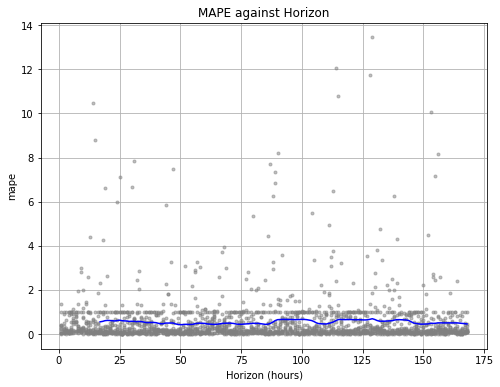

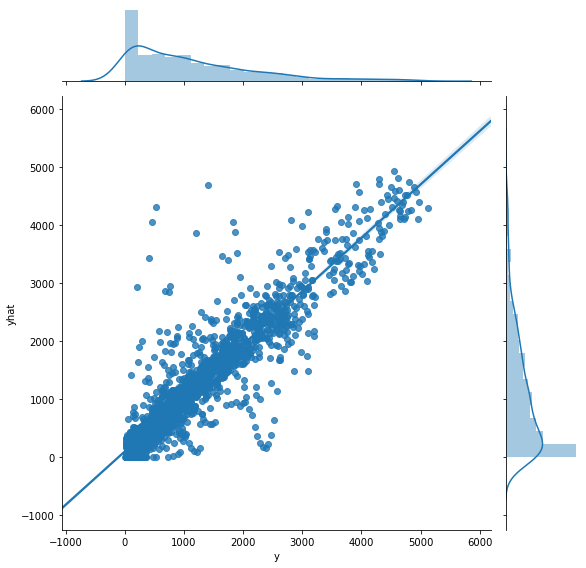

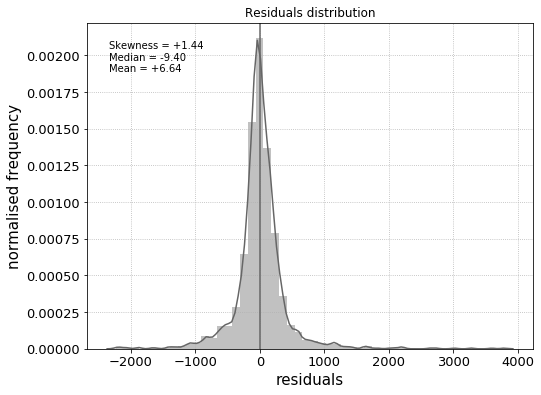

In [53]:
fig = plot_cross_validation_metric(cv_results, metric='mape', figsize=(8,6))
plt.title("MAPE against Horizon")
sns.jointplot('y', 'yhat', cv_results, kind='reg', height=8);
residuals = cv_results.yhat - cv_results.y

f, ax = plt.subplots(figsize=(8,6))
sns.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];
ax.axvline(0, color='0.4')
ax.set_title('Residuals distribution', fontsize=12)
ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=10, transform=ax.transAxes);

<br>
<br>

## Plot hourly forecast

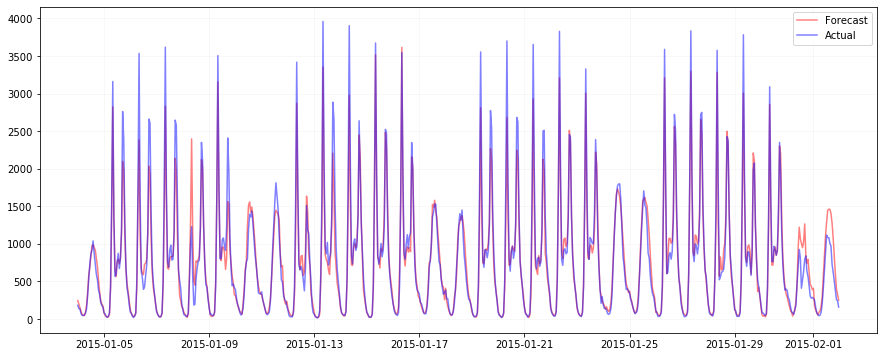

In [54]:
forecast_copy = forecast.copy()
forecast_copy.set_index('ds', inplace=True)
plt.figure(figsize=(15,6))
plt.plot(forecast_copy['2015-01-01':'2015-02-01'].index, forecast_copy['2015-01-01':'2015-02-01'].yhat, label='Forecast', alpha=0.5, c='r')
plt.plot(bike_share_df['2015-01-01':'2015-02-01'].index, bike_share_df['2015-01-01':'2015-02-01'].cnt, label='Actual', alpha=0.5, c='b')
plt.grid(alpha=0.1)
plt.legend()
ax.set_facecolor("snow");

<br>
<br>

In [ ]:
# import holidays
# holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

# ldates, lnames = [], []
# for date, name in sorted(holidays.UnitedKingdom(years=np.arange(2015, 2018 + 1)).items()):
#     ldates.append(date)
#     lnames.append(name)
# ldates, lnames = np.array(ldates), np.array(lnames)
# holidays_df['ds'], holidays_df['holiday'] = ldates, lnames
# holidays_df.sort_values('ds')